In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [1]:
from model import create_model

nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

/home/morteza/venvs/facenet/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead


In [2]:
import numpy as np
import os.path
BASE = 'UTK/'

class RaceMetadata():
    def __init__(self, race, file):
        # image file name
        self.file = file
        # race
        self.race = race

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(BASE, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        ext = os.path.splitext(i)[1]
        race = int(i.split('_')[2])
        if ext == '.jpg' or ext == '.jpeg':
            metadata.append(RaceMetadata(race, i))
    return np.array(metadata)

metadata = load_metadata(BASE)

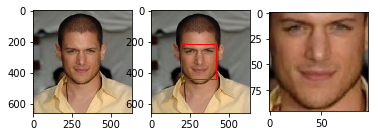

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

alignment = AlignDlib('models/landmarks.dat')
jc_orig = load_image(metadata[10].image_path())

bb = alignment.getLargestFaceBoundingBox(jc_orig)

jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

plt.subplot(131)
plt.imshow(jc_orig)

plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

plt.subplot(133)
plt.imshow(jc_aligned);

In [7]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [9]:
metadata = metadata[:3000]
embedded = np.zeros((metadata.shape[0], 128))
for i, m in enumerate(metadata):
    img_tmp = load_image(m.image_path())
    img = align_image(img_tmp)
    check = 0
    while img is None and check < 5:
        img_tmp = np.rot90(img_tmp)
        img = align_image(img_tmp)
        check+=1
    img = (img / 255.).astype(np.float32)
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

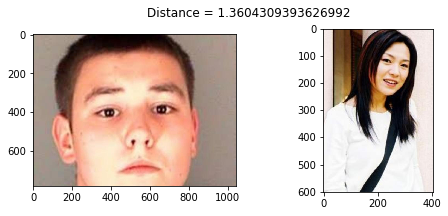

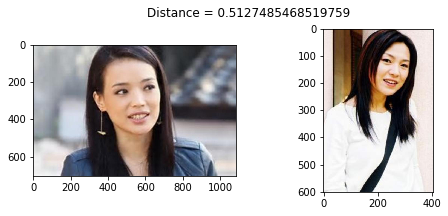

In [41]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance = {0}'.format(distance(embedded[idx1], embedded[idx2])))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path())); 

show_pair(154,2)
show_pair(139,2)

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

targets = np.array([m.race for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

X_train = embedded[train_idx]
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn, acc_svc))

KNN accuracy = 0.8333333333333334, SVM accuracy = 0.88


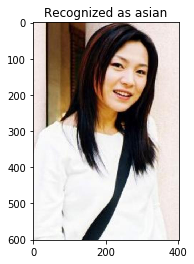

In [62]:
import warnings
warnings.filterwarnings('ignore')
RACES = ['white', 'black', 'asian', 'indian', 'others']
plt.imshow(load_image(metadata[2].image_path()))
plt.title('Recognized as {0}'.format(RACES[knn.predict([embedded[2]])[0]]));

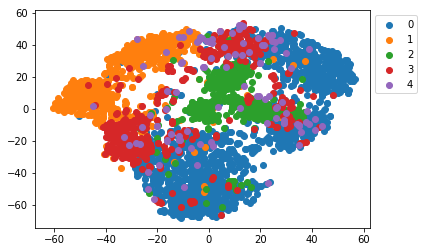

In [63]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));